In [22]:
import torch
import numpy as np

# dataset
from twaidata.torchdatasets.in_ram_ds import MRISegmentation2DDataset, MRISegmentation3DDataset
from torch.utils.data import DataLoader, random_split, ConcatDataset

# model
from trustworthai.models.base_models.source_kinet import kiunet, reskiunet, densekiunet, kiunet3d
from trustworthai.models.base_models.torchUNet import UNet, UNet3D
from trustworthai.models.base_models.deepmedic import DeepMedic

# augmentation and pretrain processing
from trustworthai.utils.augmentation.standard_transforms import RandomFlip, GaussianBlur, GaussianNoise, \
                                                            RandomResizeCrop, RandomAffine, \
                                                            NormalizeImg, PairedCompose, LabelSelect, \
                                                            PairedCentreCrop, CropZDim
# loss function
from trustworthai.utils.losses_and_metrics.tversky_loss import TverskyLoss
from trustworthai.utils.losses_and_metrics.misc_metrics import IOU
from trustworthai.utils.losses_and_metrics.dice import dice, DiceMetric
from trustworthai.utils.losses_and_metrics.dice_losses import DiceLoss
from trustworthai.utils.losses_and_metrics.power_jaccard_loss import PowerJaccardLoss
from torch.nn import BCELoss, MSELoss

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper, get_trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
import pytorch_lightning as pl

# misc
import os
import torch
import matplotlib.pyplot as plt
import torch
from torchinfo import summary

### Set the seed

In [2]:
seed = 3407
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [3]:
### Set the GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "1,2" # blocks gpu 0
# torch.cuda.device_count()

### define datasets and dataloaders

In [4]:
root_dir = "/disk/scratch/s2208943/ipdis/preprep/out_data/collated/"
wmh_dir = root_dir + "WMH_challenge_dataset/"
ed_dir = root_dir + "EdData/"

In [5]:
domains = [
            wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
          ] + [
            ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
          ]

In [6]:
# augmentation definintion
transforms = PairedCompose([
        LabelSelect(label_id=1),
        RandomFlip(p=0.5, orientation="horizontal"),
        GaussianBlur(p=0.5, kernel_size=7, sigma=(.1, 1.5)),
        GaussianNoise(p=0.2, mean=0, sigma=0.2),
        RandomAffine(p=0.2, shear=(.1,3.)),
        RandomAffine(p=0.2, degrees=5),
        RandomResizeCrop(p=1., scale=(0.6, 1.), ratio=(3./4., 4./3.))
    ])

In [7]:
# function to do train validate test split
test_proportion = 0.1
validation_proportion = 0.2

def train_val_test_split(dataset, val_prop, test_prop, seed):
    # I think the sklearn version might be prefereable for determinism and things
    # but that involves fiddling with the dataset implementation I think....
    size = len(dataset)
    test_size = int(test_prop*size) 
    val_size = int(val_prop*size)
    train_size = size - val_size - test_size
    train, val, test = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(seed))
    return train, val, test

In [27]:
# load datasets
# this step is quite slow, all the data is being loaded into memory
datasets_domains = [MRISegmentation2DDataset(root_dir, domain, transforms=transforms) for domain in domains]
#datasets_domains = [MRISegmentation3DDataset(root_dir, domain, transforms=None) for domain in domains]

# split into train, val test datasets
datasets = [train_val_test_split(dataset, validation_proportion, test_proportion, seed) for dataset in datasets_domains]

# concat the train val test datsets
train_dataset = ConcatDataset([ds[0] for ds in datasets])
val_dataset = ConcatDataset([ds[1] for ds in datasets])
test_dataset = ConcatDataset([ds[2] for ds in datasets])

In [28]:
len(train_dataset), len(val_dataset), len(test_dataset)

(11249, 3213, 1606)

In [29]:
# define dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

In [30]:
img, label = datasets_domains[3][0]

In [31]:
#img, label = train_dataset[3]

In [32]:
img.shape

torch.Size([3, 224, 160])

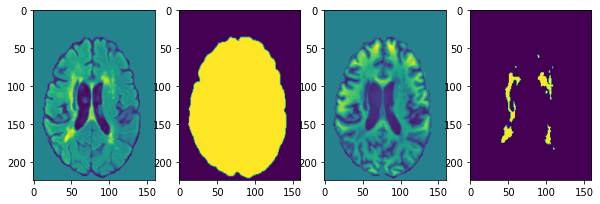

In [33]:
# plot an image
img, label = train_dataset[10]
#img, label = datasets_domains[6][121]
plt.figure(figsize=(10,5))
plt.subplot(1,4,1)
plt.imshow(img.numpy()[0,:,:])
plt.subplot(1,4,2)
plt.imshow(img.numpy()[1,:,:])
plt.subplot(1,4,3)
plt.imshow(img.numpy()[2,:,:])
plt.subplot(1,4,4)
plt.imshow((label.numpy()==1)[0,:,:])
plt.show()

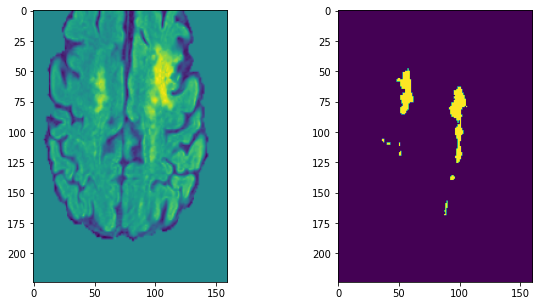

In [49]:
# plot an image
img, label = test_dataset[65]
#img, label = datasets_domains[6][121]
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img.numpy()[0,:,:])
plt.subplot(1,2,2)
plt.imshow((label.numpy()==1)[0,:,:]); plt.show()

### setup model

In [35]:
# from trustworthai.models.base_models.source_kinet import kiunet, reskiunet, densekiunet, kiunet3d
# from trustworthai.models.base_models.torchUNet import UNet, UNet3D
# from trustworthai.models.base_models.deepmedic import DeepMedic

in_channels = 3
out_channels = 1

# fpr 2D models
# select a 2D dataloader
# for standard UNet
model = UNet(in_channels, out_channels, init_features=32, dropout_p=0.)

# model = kiunet(in_channels, out_channels)
# model = densekiunet(in_channels, out_channels)
# model = reskiunet(in_channels, out_channels)

# # deepmedic
# SCALE_FACTORS = ((3, 3, 3), (1, 1, 1))
# FEATURE_MAPS = (30, 30, 40, 40, 40, 40, 50, 50)
# FULLY_CONNECTED = (250, 250)
# DROPOUT = (.0, .5, .5)
# model = DeepMedic(in_channels,
#                  out_channels,
#                  scale_factors=SCALE_FACTORS,
#                  feature_maps=FEATURE_MAPS,
#                  fully_connected=FULLY_CONNECTED,
#                  dropout=DROPOUT)

# # for 3D models
# # select a 3D dataloader (note you will have a very few validation/test samples when using just the WMH dataset)
# # as there are only 60 scans across the entire dataset.

# # for 3D Unet:
# model = UNet3D(in_channels=3, out_channels=1, init_features=32, dropout_p=0.)

# # for kinet
# model = kiunet3d(c=in_channels, num_classes=out_channels)


# SCALE_FACTORS = ((5, 5, 5), (3, 3, 3), (1, 1, 1))
# FEATURE_MAPS = (30, 30, 40, 40, 40, 40, 50, 50)
# FULLY_CONNECTED = (250, 250)
# DROPOUT = (.0, .5, .5)
# model = DeepMedic(in_channels,
#                  out_channels,
#                  scale_factors=SCALE_FACTORS,
#                  feature_maps=FEATURE_MAPS,
#                  fully_connected=FULLY_CONNECTED,
#                  dropout=DROPOUT)

loss = DiceLoss()
# loss = TverskyLoss()
# loss = PowerJaccardLoss()

In [36]:
metrics=None#[DiceMetric()]
# note metrics only work properly when not using distributed stategies I think.
# see pytorchlightning guidance on metrics.

model = StandardLitModelWrapper(model, train_dataloader, test_dataloader, val_dataloader, None, loss, metrics)

In [37]:
checkpoint_dir = "/disk/scratch/s2208943/results/"
strategy = None
# strategy = "deepspeed_stage_2"
# strategy = "dp"
#strategy = "deepspeed_stage_2_offload"

accelerator="gpu"
devices=1
max_epochs=400
precision = 16

checkpoint_callback = ModelCheckpoint(checkpoint_dir, save_top_k=2, monitor="val_loss")
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=50, verbose="False", mode="min", check_finite=True)
trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stop_callback],
    accelerator=accelerator,
    devices=devices,
    max_epochs=max_epochs,
    strategy=strategy,
    precision=precision,
    default_root_dir=checkpoint_dir
)


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [38]:
# where your checkpoints are saved
checkpoint_dir = "/disk/scratch/s2208943/results/"
strategy = None
# strategy = "deepspeed_stage_2"
# strategy = "dp"
#strategy = "deepspeed_stage_2_offload"

precision = None
precision = 16
trainer = get_trainer(checkpoint_dir, accelerator="gpu", devices=1, max_epochs=400,
                      strategy=strategy, precision=precision
                     )

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [39]:
print(torch.version.cuda)

11.3


### train

In [41]:
trainer.fit(model, train_dataloader, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | model           | UNet       | 7.8 M 
1 | loss            | DiceLoss   | 0     
2 | logging_metrics | ModuleList | 0     
-----------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
15.526    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 362it [00:00, ?it/s]

In [26]:
checkpoint_callback.best_model_path


''